In [1]:
import os
from konlpy.tag import Mecab
tokenizer = Mecab()#속도가 느려 형태소 분석기는 교체하였다
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = tokenizer.pos(line)
        res = []
        for w in words:
            res.append(w[0]+'__'+w[1].lower())    # 단어와 태그를 같이 태깅한다 
        tokenized.append(res)

In [2]:
from numpy import dot
from numpy.linalg import norm
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev


In [3]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  


In [4]:
model.save("word2vec.model")
model = Word2Vec.load("word2vec.model")
print(model.wv.most_similar(positive=['사랑__nng']))
print(model.wv.most_similar(positive=['연극__nng']))
print(model.wv.most_similar(positive=['영화__nng']))

[('만남__nng', 0.6194968223571777), ('키스__nng', 0.6154981255531311), ('우정__nng', 0.609313428401947), ('고민__nng', 0.5891116857528687), ('행복__nng', 0.5825580954551697), ('경험__nng', 0.5767485499382019), ('마음__nng', 0.5736018419265747), ('추억__nng', 0.5695721507072449), ('기억__nng', 0.5677180290222168), ('열정__nng', 0.553215503692627)]
[('공연__nng', 0.7382909655570984), ('뮤지컬__nng', 0.7372533679008484), ('오페라__nng', 0.7295865416526794), ('음악__nng', 0.7247467637062073), ('미술__nng', 0.7198129296302795), ('소설__nng', 0.7168273329734802), ('무용__nng', 0.7138805985450745), ('작업__nng', 0.7094038724899292), ('시나리오__nng', 0.6948158144950867), ('TV__sl', 0.6927939653396606)]
[('다큐멘터리__nng', 0.8241325616836548), ('작품__nng', 0.792523980140686), ('드라마__nng', 0.7199833393096924), ('영상__nng', 0.6768871545791626), ('이미지__nng', 0.6603915095329285), ('애니메이션__nng', 0.64222651720047), ('소설__nng', 0.632978618144989), ('코미디__nng', 0.6287373900413513), ('화면__nng', 0.6121612191200256), ('연기__nng', 0.6096770167350769)]


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from collections import Counter
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = tokenizer.pos(line) 
            for word in tokenlist:
                if 'NNG' == word[1] or 'NNP' == word[1] or 'VV' == word[1]:#명사/동사
                    result.append((word[0]+'__'+word[1].lower())) 
#     return ' '.join(result)
    return result

In [6]:
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [7]:
#tfidf를 문서 두개에 적용하게 되면 빈도수 상위 기준 대부분이 df가 같다. 즉 idf가 같다.
#그러니 wordcount로 바꿔 비율을 구해보기로 했다.
word_counts_art = Counter(art)
word_counts_gen = Counter(gen)

#art에 등장한 단어 카운트를 gen에 등장한 카운트로 나눈다
word_ratios1 = {word: count / word_counts_gen[word] if word in word_counts_gen else 1 for word, count in word_counts_art.items() if count > 30}
sorted_word_ratios_art = sorted(word_ratios1.items(), key=lambda x: x[1], reverse=True)
#gen에 등장한 단어 카운트를 art에 등장한 카운트로 나눈다
word_ratios2 = {word: count / word_counts_art[word] if word in word_counts_art else 1 for word, count in word_counts_gen.items() if count > 30}
sorted_word_ratios_gen = sorted(word_ratios2.items(), key=lambda x: x[1], reverse=True)
print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(sorted_word_ratios_art[i][0], end=', ')
print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(sorted_word_ratios_gen[i][0], end=', ')


예술영화를 대표하는 단어들:
선화__nng, 피아니스트__nng, 북극__nng, 안나__nnp, 북한__nnp, 수현__nnp, 레오__nnp, 뮤지션__nnp, 황제__nng, 딘__nnp, 파리__nng, 수녀__nng, 로마__nng, 요괴__nng, 토미__nnp, 북__nng, 제인__nng, 준__nnp, 연주__nng, 피아노__nng, 지갑__nng, 마비__nng, 기적__nng, 천재__nng, 신부__nng, 콘서트__nng, 나치__nng, 공개__nng, 시인__nng, 샘__nnp, 떠오르__vv, 고양이__nng, 패션__nng, 필립__nnp, 미군__nng, 청춘__nng, 로맨스__nng, 외면__nng, 면__nng, 케빈__nnp, 병사__nng, 창__nng, 마리아__nnp, 진심__nng, 편지__nng, 용서__nng, 첫눈__nng, 아담__nng, 생애__nng, 고수__nng, 런던__nnp, 닮__vv, 공연__nng, 이탈리아__nnp, 영어__nng, 하루하루__nng, 유학__nng, 치열__nng, 선고__nng, 실화__nng, 러브__nng, 명성__nng, 흔들리__vv, 대원__nng, 이별__nng, 기도__nng, 카페__nng, 조금__nng, 사연__nng, 선언__nng, 무대__nng, 음악__nng, 연애__nng, 치유__nng, 꿈꾸__vv, 오페라__nng, 가난__nng, 흑인__nng, 청년__nng, 피터__nnp, 교통사고__nng, 최대__nng, 매혹__nng, 아픔__nng, 프랑스__nnp, 열정__nng, 대전__nng, 평온__nng, 아프리카__nnp, 모두__nng, 기자__nng, 아빠__nng, 평생__nng, 의__nng, 멤버__nng, 디__nng, 절친__nng, 노래__nng, 미국인__nng, 인생__nng, 

일반영화를 대표하는 단어들:
페스트__nnp, 인디__nnp, 포럼__nng, 지사__nng, 페스__nnp, 마사지__nng, 형

In [8]:
#단어중복문제를 거의 해결했으니 그대로 사용하도록 하겠다.
target_art, target_gen = [], []
for i in range(100):
    target_art.append(sorted_word_ratios_art[i][0])
for i in range(100):
    target_gen.append(sorted_word_ratios_gen[i][0])

In [9]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [10]:
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [11]:
total_counts = Counter('')
temp = []
for i in range(len(genre)):
    word_counts = Counter(genre[i])
    total_counts = total_counts + word_counts
    temp.append(word_counts)
temp2 =[]
for i in range(len(genre)):
    word_ratios = {word: count / total_counts[word] if word in total_counts else 1 for word, count in temp[i].items() if count > 5}
    sorted_word_ratios = sorted(word_ratios.items(), key=lambda x: x[1], reverse=True)
    temp2.append(sorted_word_ratios)

for tt in range(len(temp2)) :
    for i in range(min(30,len(temp2[tt]))) :
        print(genre_name[tt] + ':'+str(temp2[tt][i]))
    


SF:('옥스__nnp', 1.0)
SF:('마토바__nnp', 1.0)
SF:('라임__nng', 1.0)
SF:('앤더튼__nnp', 1.0)
SF:('켈빈__nnp', 1.0)
SF:('위저드__nnp', 1.0)
SF:('미노스__nng', 1.0)
SF:('영군__nng', 1.0)
SF:('분파__nng', 1.0)
SF:('살인귀__nng', 1.0)
SF:('영건__nng', 1.0)
SF:('키오__nnp', 0.9)
SF:('타란__nng', 0.8888888888888888)
SF:('성냥팔이__nng', 0.8571428571428571)
SF:('쇼타로__nnp', 0.8571428571428571)
SF:('프리크__nnp', 0.8571428571428571)
SF:('젠슨__nnp', 0.8571428571428571)
SF:('섹터__nng', 0.8461538461538461)
SF:('히노__nnp', 0.8333333333333334)
SF:('수퍼맨__nnp', 0.7777777777777778)
SF:('송현__nnp', 0.7777777777777778)
SF:('에일리언__nnp', 0.7272727272727273)
SF:('스타크__nnp', 0.6764705882352942)
SF:('디셉티콘__nnp', 0.6363636363636364)
SF:('롯__nnp', 0.6153846153846154)
SF:('리플리__nnp', 0.6153846153846154)
SF:('강두__nng', 0.6)
SF:('어니스트__nnp', 0.6)
SF:('디비전__nng', 0.5833333333333334)
SF:('수트__nnp', 0.5652173913043478)
가족:('베일리__nnp', 1.0)
가족:('씨제이__nnp', 1.0)
가족:('소누__nnp', 1.0)
가족:('크리쉬나__nnp', 0.8571428571428571)
가족:('펠리칸__nnp', 0.7777777777777778)
가족:('벤트

In [12]:
#장르별 키워드도 잘 뽑힌 것 처럼 보이니 그냥 사용하겠다.
attributes = []
for tt in range(len(temp2)) :
    attr = []
    for i in range(min(30,len(temp2[tt]))) :
        attr.append(temp2[tt][i][0])
    attributes.append(attr)

In [13]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [14]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [15]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.44842234
SF 공연 -0.0943306
SF 공포(호러) -0.39042312
SF 기타 -0.43504304
SF 다큐멘터리 -0.20743097
SF 드라마 0.1718045
SF 멜로로맨스 0.09994075
SF 뮤지컬 -0.8278857
SF 미스터리 -0.15581831
SF 범죄 0.28215367
SF 사극 -1.0121255
SF 서부극(웨스턴) -0.74540716
SF 성인물(에로) 0.22491649
SF 스릴러 0.16000292
SF 애니메이션 -0.30289438
SF 액션 0.07158694
SF 어드벤처 -1.131225
SF 전쟁 -0.5130222
SF 코미디 0.17861211
SF 판타지 -0.60463583
가족 공연 0.60111123
가족 공포(호러) 0.1311287
가족 기타 -0.013906348
가족 다큐멘터리 0.16236721
가족 드라마 0.6788564
가족 멜로로맨스 0.753501
가족 뮤지컬 -0.60516894
가족 미스터리 0.5433901
가족 범죄 0.82642585
가족 사극 -0.6983124
가족 서부극(웨스턴) -0.69596595
가족 성인물(에로) 0.6893702
가족 스릴러 0.7017431
가족 애니메이션 -0.048726127
가족 액션 0.4543038
가족 어드벤처 -0.59293646
가족 전쟁 0.01531762
가족 코미디 0.7946041
가족 판타지 -0.23993891
공연 공포(호러) -0.39404967
공연 기타 -0.27724588
공연 다큐멘터리 -0.07149775
공연 드라마 0.32533467
공연 멜로로맨스 0.34512913
공연 뮤지컬 -0.8043724
공연 미스터리 -0.1663478
공연 범죄 0.50032777
공연 사극 -0.96673095
공연 서부극(웨스턴) -0.83096504
공연 성인물(에로) 0.4423639
공연 스릴러 0.27199394
공연 애니메이션 -0.39017734
공연 액션 0.124

<AxesSubplot:>

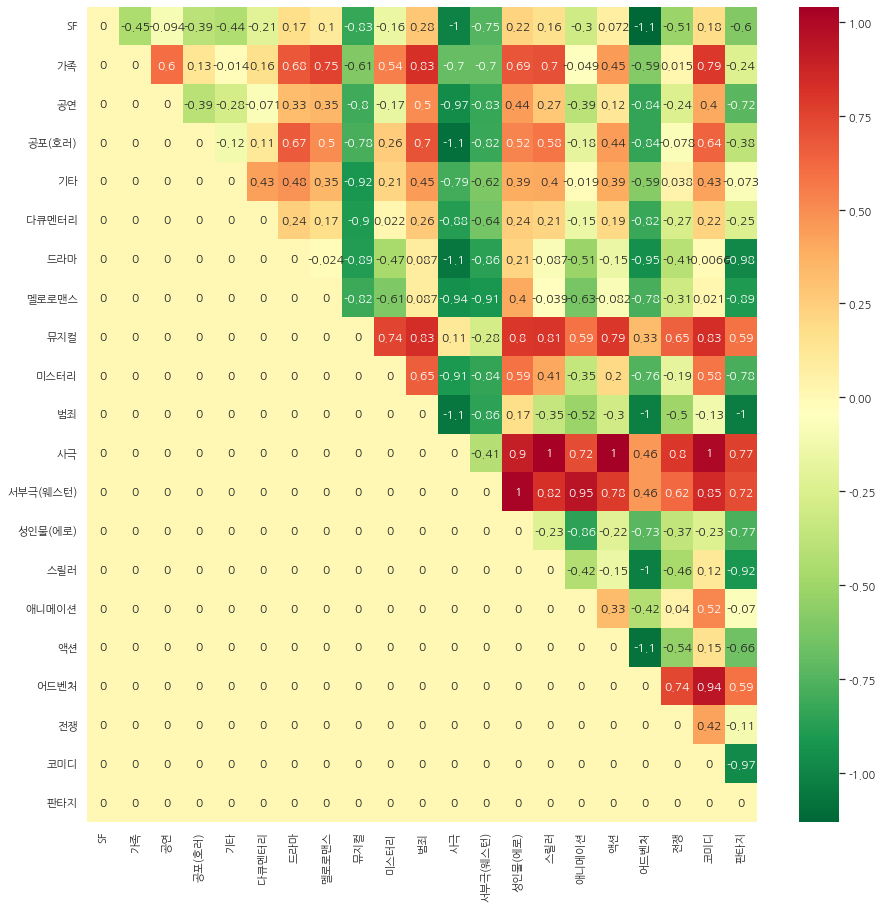

In [16]:
import numpy as np; 
import seaborn as sns; 
import matplotlib.pyplot as plt
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(15, 15))
ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax